In [2]:
from scipy.integrate import odeint

In [3]:
#Model
# 0-2 variables K27me at promoter; 3-5 variables K27me3 at bodies; 6 variable K4me3 at promoter.
# K4me0K27me0 is given by the conservation of histones.
# m1 and m2 are the feedback rates, parametrised by F and the coupling coupl between regions.
def model_ann_DE_excl(X, t, kb1, kb2, F, E, kac, coupl):
    m1=(kb1+F*(X[5]*coupl+X[2])/(1+coupl))*(1-E)
    m2=(kb2+F*(X[2]*coupl+X[5])/(1+coupl))*(1-E)
    du=np.zeros(7)
    du[0]=X[1]-X[0]*m1+(1-X[0]-X[1]-X[2]-X[6])*m1-X[0]
    du[1]=X[2]-X[1]*m1+X[0]*m1-X[1]
    du[2]=-X[2]+X[1]*m1
    du[3]=X[4]-X[3]*m2+(1-X[3]-X[4]-X[5])*m2-X[3]
    du[4]=X[5]-X[4]*m2+X[3]*m2-X[4]
    du[5]=-X[5]+X[4]*m2
    du[6]=2*(kac*(1-X[0]-X[1]-X[2]-X[6])-X[6])#Factor of two to scale up time, activating marks tendto be faster.
    return du

In [4]:
def branches_short(pars):
    #Function to solve the ODEs of the model
    #Two branches that start from each end of the E variable values, to sample the solutions evenly.
    cell_cycle=22
    tspan=np.linspace(0,cell_cycle,10)
    evolK27f=np.array([], dtype=np.float64).reshape(0,2)
    evolK27pf=np.array([], dtype=np.float64).reshape(0,2)
    evolK4f=np.array([], dtype=np.float64).reshape(0,2)
    evolunmf=np.array([], dtype=np.float64).reshape(0,2)
    Estep=0.04
    Frange=Estep*4.5
    for Ev in range(5):
        for i in range(20): #Cell cycles for equilibration
            if (i==0):
                u0=[0.01,0,0.5,0.01,0,0.5,0.05]
            else:
                u0=sol[len(sol)-1]/2.0
            pars_ann = (pars[0], pars[1], pars[2],  Ev*Estep, pars[3], pars[4])
            sol=odeint(model_ann_DE_excl, u0, tspan, args=pars_ann)
        tspan=np.linspace(0, 22, 100)
        u0=sol[len(sol)-1]/2.0
        sol = odeint(model_ann_DE_excl, u0, tspan, args=pars_ann) #Equilibrated solution to obtain averages from
        cc_avg=np.zeros(7)
        for i in range(len(sol)):
            for j in range(len(cc_avg)):
                cc_avg[j]+=sol[i][j]/100 #Taking the average over the cell cycle.
        addendum=[Ev*Estep,cc_avg[5]]
        evolK27f=np.vstack([evolK27f,addendum])
        addendum=[Ev*Estep,cc_avg[2]]
        evolK27pf=np.vstack([evolK27pf,addendum])
        addendum=[Ev*Estep,cc_avg[6]]
        evolK4f=np.vstack([evolK4f,addendum])
        addendum=[Ev*Estep,1-sum(cc_avg[0:3])-cc_avg[6]]
        evolunmf=np.vstack([evolunmf,addendum])
    
    #Backwards branch
    evolK27b=np.array([], dtype=np.float64).reshape(0,2)
    evolK27pb=np.array([], dtype=np.float64).reshape(0,2)
    evolK4b=np.array([], dtype=np.float64).reshape(0,2)
    evolunmb=np.array([], dtype=np.float64).reshape(0,2)
    for Ev in range(5):
        for i in range(20): #Cell cycles for equilibration
            if (i==0):
                u0=[0.01,0,0.5,0.01,0,0.5,0.05]
            else:
                u0=sol[len(sol)-1]/2.0
            pars_ann = (pars[0], pars[1], pars[2],  Frange-Ev*Estep, pars[3], pars[4]) #Note the change to Frange-Ev*Estep
            sol=odeint(model_ann_DE_excl, u0, tspan, args=pars_ann)
        tspan=np.linspace(0, 22, 100)
        u0=sol[len(sol)-1]/2.0
        sol = odeint(model_ann_DE_excl, u0, tspan, args=pars_ann)
        cc_avg=np.zeros(7)
        for i in range(len(sol)):
            for j in range(len(cc_avg)):
                cc_avg[j]+=sol[i][j]/100
        addendum=[Frange-Ev*Estep,cc_avg[5]]
        evolK27b=np.vstack([evolK27b,addendum])
        addendum=[Frange-Ev*Estep,cc_avg[2]]
        evolK27pb=np.vstack([evolK27pb,addendum])
        addendum=[Frange-Ev*Estep,cc_avg[6]]
        evolK4b=np.vstack([evolK4b,addendum])
        addendum=[Frange-Ev*Estep,1-sum(cc_avg[0:3])-cc_avg[6]]
        evolunmb=np.vstack([evolunmb,addendum])


    return evolK27f,evolK27b, evolK27pf, evolK27pb, evolunmf, evolunmb,evolK4f,evolK4b


In [5]:
def heaviside(x):
    if x > 0:
        y = 1
    else:
        y = 0
    return y


In [6]:
# Assuming the functions branches_short! and heaviside are already defined in Python
import random
import diptest
import statistics


def cluster_model(cluster_pars, npars):
    # Obtain random parameters
    # Gaussian noise with a sigma=10% of the mean parameter.
    branches_randomp = []
    random_pars = []
    for pars in range(npars):
        vector = [np.random.normal(cluster_pars[i], cluster_pars[i] * 0.1) for i in range(5)]
        random_pars.append(vector)

    # Cycle for branch over parameters.
    for pars in range(npars):
        evolK27f,evolK27b, evolK27pf, evolK27pb, evolunmf, evolunmb,evolK4f,evolK4b = branches_short(
            [random_pars[pars][0], random_pars[pars][1], random_pars[pars][2], random_pars[pars][3], random_pars[pars][4]])

        # Paste together the branches
        brpfullK4 = np.concatenate((evolK4f[:,1], evolK4b[:,1]))
        brpfullK27 = np.concatenate((evolK27f[:,1], evolK27b[:,1]))
        brpfullK27p = np.concatenate((evolK27pf[:,1], evolK27pb[:,1]))
        brmatrix = np.column_stack((brpfullK4, brpfullK27,brpfullK27p ))
        if pars%30==0:
            print(pars)
        # And then you push the matrix into the vector of matrices.
        branches_randomp.append(brmatrix)

    # Compute RNA and variables
    RNA_branch = []
    
    corrK4K27p = []
    corrK4K27b = []
        
    maxK4p = []
    maxK27p = []
    maxK27b = []
    minK4p = []
    minK27p = []
    minK27b = []

    for pars in range(npars):
        # Add noise
        for j in range(len(branches_randomp[pars][:, 0])):
            randnormalvar = np.random.normal(0.1, 0.05)
            branches_randomp[pars][j, 0] = abs(branches_randomp[pars][j, 0] + randnormalvar)
            randnormalvar = np.random.normal(0.1, 0.05)
            branches_randomp[pars][j, 1] = abs(branches_randomp[pars][j, 1] + randnormalvar)
            randnormalvar = np.random.normal(0.1, 0.05)
            branches_randomp[pars][j, 2] = abs(branches_randomp[pars][j, 2] + randnormalvar)
        
        #Correlations
        cK4K27p=np.corrcoef(branches_randomp[pars][:, 0],branches_randomp[pars][:, 2])[0,1]
        corrK4K27p.append(cK4K27p)
        cK4K27b=np.corrcoef(branches_randomp[pars][:, 0],branches_randomp[pars][:, 1])[0,1]
        corrK4K27b.append(cK4K27b)
        
        #Dynamical range
        maxK4p.append(np.max(branches_randomp[pars][:, 0]))
        maxK27p.append(np.max(branches_randomp[pars][:, 2]))
        maxK27b.append(np.max(branches_randomp[pars][:, 1]))
        minK4p.append(np.min(branches_randomp[pars][:, 0]))
        minK27p.append(np.min(branches_randomp[pars][:, 2]))
        minK27b.append(np.min(branches_randomp[pars][:, 1]))

        # Normalize
        branches_randomp[pars][:, 0] = (branches_randomp[pars][:, 0] - np.min(branches_randomp[pars][:, 0])) / (
            np.max(branches_randomp[pars][:, 0]) - np.min(branches_randomp[pars][:, 0])    )
        branches_randomp[pars][:, 1] = (branches_randomp[pars][:, 1] - np.min(branches_randomp[pars][:, 1])) / (
            np.max(branches_randomp[pars][:, 1]) - np.min(branches_randomp[pars][:, 1])    )
        branches_randomp[pars][:, 2] = (branches_randomp[pars][:, 2] - np.min(branches_randomp[pars][:, 2])) / (
            np.max(branches_randomp[pars][:, 2]) - np.min(branches_randomp[pars][:, 2])    )

        #Obtain transcriptional ouput from histone mods.
        RNA_vector=np.zeros(10)
        for i in range(10):
            if (branches_randomp[pars][i, 0]-(branches_randomp[pars][i, 1]+branches_randomp[pars][i, 2])/2>0):
                RNA_vector[i] = (branches_randomp[pars][i, 0]-(branches_randomp[pars][i, 1]+branches_randomp[pars][i, 2])/2)*heaviside(1-(branches_randomp[pars][i, 1]+branches_randomp[pars][i, 2]))
            else:
                RNA_vector[i] = 0
        #Add noise to the transcriptional output
        for i in range(len(RNA_vector)):
            randnormalvar = np.random.normal(0.1, 0.05)
            RNA_vector[i] = abs(RNA_vector[i] + randnormalvar)

        RNA_vector = (RNA_vector - np.min(RNA_vector)) / (np.max(RNA_vector) - np.min(RNA_vector))
        RNA_branch.append(RNA_vector)

    #Processing of the stadistics, as done with the experimental data, but for modelling data (synthetic data).
    K27bodyc5=np.array([], dtype=np.float64).reshape(0,1)
    K27promc5=np.array([], dtype=np.float64).reshape(0,1)
    K4promc5=np.array([], dtype=np.float64).reshape(0,1)
    K27bodyc5full=np.array([], dtype=np.float64).reshape(0,1)
    K27promc5full=np.array([], dtype=np.float64).reshape(0,1)
    K4promc5full=np.array([], dtype=np.float64).reshape(0,1)
    for i in range(npars):
        x=np.transpose(branches_randomp[i])[0]
        K4promc5full=np.vstack([K4promc5full,x.reshape(10,1)])
        x=np.delete(x, x.argmax())
        x=np.delete(x, x.argmin())
        K4promc5=np.vstack([K4promc5,x.reshape(8,1)])
        x=np.transpose(branches_randomp[i])[1]
        K27bodyc5full=np.vstack([K27bodyc5full,x.reshape(10,1)])
        x=np.delete(x, x.argmax())
        x=np.delete(x, x.argmin())
        K27bodyc5=np.vstack([K27bodyc5,x.reshape(8,1)])
        x=np.transpose(branches_randomp[i])[2]
        K27promc5full=np.vstack([K27promc5full,x.reshape(10,1)])
        x=np.delete(x, x.argmax())
        x=np.delete(x, x.argmin())
        K27promc5=np.vstack([K27promc5,x.reshape(8,1)])
    dip_K4p=diptest.dipstat(np.transpose(K4promc5)[0])
    dip_K27b=diptest.dipstat(np.transpose(K27bodyc5)[0])
    dip_K27p=diptest.dipstat(np.transpose(K27promc5)[0])
    corrK4K27bmed=statistics.median(corrK4K27b)
    corrK4K27pmed=statistics.median(corrK4K27p)
    dynrangeK4=(statistics.median(maxK4p)-statistics.median(minK4p))/statistics.median(maxK4p)
    dynrangeK27b=(statistics.median(maxK27b)-statistics.median(minK27b))/statistics.median(maxK27b)
    dynrangeK27p=(statistics.median(maxK27p)-statistics.median(minK27p))/statistics.median(maxK27p)
    stats=[dip_K4p, dip_K27b, dip_K27p, corrK4K27pmed, corrK4K27bmed, dynrangeK4, dynrangeK27b, dynrangeK27p]
    
    return stats, RNA_branch, branches_randomp
    

In [7]:
import numpy as np

np.random.seed(26401)

#Simulate the three K27 clusters, 20 replicates of each stochastic simulation.

c_pars = [[0.42, 0.28, 3.6, 0.4, 0.3], 
          [0.42, 0.28, 3.6, 0.4, 0.03],
          [0.52, 0.34, 3.2, 0.4, 0.3]]


ngenes=[52, 66, 34]
nreps=20
sts=[]
for cluster in range(3):
    st=[]
    for reps in range(nreps):
        cluster_pars = c_pars[cluster]
        npars = ngenes[cluster]
        st_rep, rna_rep, br_rep=cluster_model(cluster_pars, npars)
        st.append(st_rep)
    sts.append(np.transpose(st))

0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
60
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30
0
30


In [11]:
import pandas as pd
#Loading the experimental data.
correl_df=pd.read_csv('correls_K4K27_clusters.csv', index_col=0)

In [12]:
dyn_range_df=pd.read_csv('dyn_range_clusters.csv', index_col=0)

In [13]:
HDS_clust=pd.read_csv('HDS_clusters.csv', index_col=0)

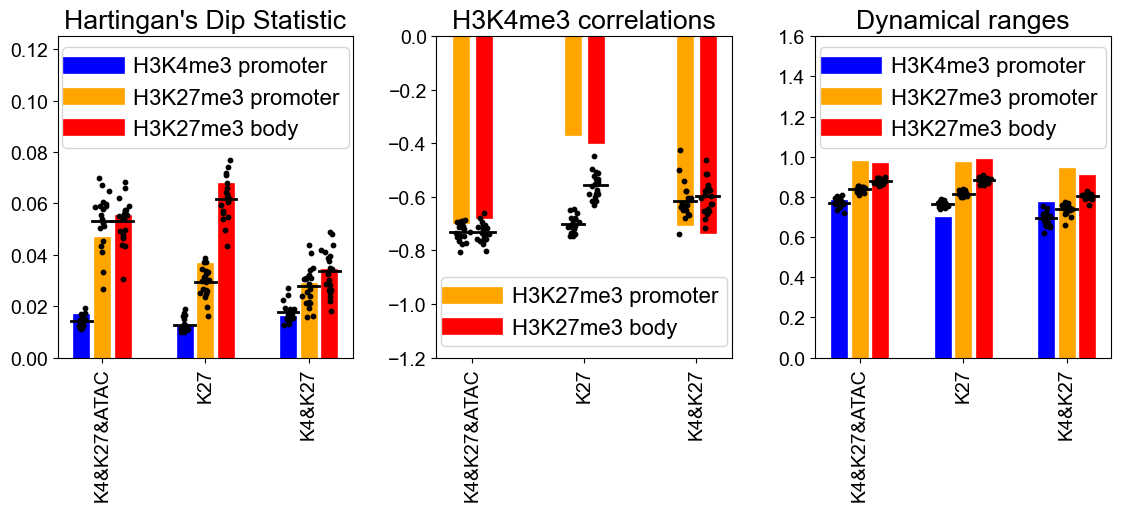

In [23]:
from matplotlib import rcParams
from matplotlib import rc
import matplotlib.pyplot as plt 

#Plotting the quantitative comparison with experimental data

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

np.random.seed(27)

fig, ax=plt.subplots(1,3, figsize=(11.6,5.4))
xax=np.arange(3)
cluster_names=['K4&K27&ATAC', 'K27', 'K4&K27']
cluster_nums=[0,5,9]
for i in range(3):
    if i==0:
        ax[0].plot([xax[i]-0.2,xax[i]-0.2],[0,HDS_clust.iloc[cluster_nums[i]].K4], color="blue", label="H3K4me3 promoter", linewidth=12)
        ax[0].scatter(xax[i]-0.2+np.random.normal(0, 0.025,nreps), sts[i][0], color='black', zorder=2, s=10)
        ax[0].plot([xax[i]-0.3,xax[i]-0.1],[np.mean(sts[i][0]),np.mean(sts[i][0])], color="black", linewidth=2)
        ax[0].plot([xax[i],xax[i]],[0,HDS_clust.iloc[cluster_nums[i]].K27p], color="orange", label="H3K27me3 promoter", linewidth=12)
        ax[0].scatter(xax[i]+np.random.normal(0, 0.025,nreps), sts[i][2], color='black', zorder=2, s=10)
        ax[0].plot([xax[i]-0.1,xax[i]+0.1],[np.mean(sts[i][2]),np.mean(sts[i][2])], color="black", linewidth=2)
        ax[0].plot([xax[i]+0.2,xax[i]+0.2],[0,HDS_clust.iloc[cluster_nums[i]].K27b], color="red", label="H3K27me3 body", linewidth=12)
        ax[0].scatter(xax[i]+0.2+np.random.normal(0, 0.025,nreps), sts[i][1], color='black', zorder=2, s=10)
        ax[0].plot([xax[i]+0.1,xax[i]+0.3],[np.mean(sts[i][1]),np.mean(sts[i][1])], color="black", linewidth=2)
    else:
        ax[0].plot([xax[i]-0.2,xax[i]-0.2],[0,HDS_clust.iloc[cluster_nums[i]].K4], color="blue",  linewidth=12)
        ax[0].scatter(xax[i]-0.2+np.random.normal(0, 0.025,nreps), sts[i][0], color='black', zorder=2, s=10)
        ax[0].plot([xax[i]-0.3,xax[i]-0.1],[np.mean(sts[i][0]),np.mean(sts[i][0])], color="black", linewidth=2)
        ax[0].plot([xax[i],xax[i]],[0,HDS_clust.iloc[cluster_nums[i]].K27p], color="orange", linewidth=12)
        ax[0].scatter(xax[i]+np.random.normal(0, 0.025,nreps), sts[i][2], color='black', zorder=2, s=10)
        ax[0].plot([xax[i]-0.1,xax[i]+0.1],[np.mean(sts[i][2]),np.mean(sts[i][2])], color="black", linewidth=2)
        ax[0].plot([xax[i]+0.2,xax[i]+0.2],[0,HDS_clust.iloc[cluster_nums[i]].K27b], color="red", linewidth=12)
        ax[0].scatter(xax[i]+0.2+np.random.normal(0, 0.025,nreps), sts[i][1], color='black', zorder=2, s=10)
        ax[0].plot([xax[i]+0.1,xax[i]+0.3],[np.mean(sts[i][1]),np.mean(sts[i][1])], color="black", linewidth=2)
ax[0].set_xticks(xax, cluster_names, rotation=90)
ax[0].set_ylim([0,0.125])

ax[0].legend(loc='upper center')

ax[0].set_title('Hartingan\'s Dip Statistic')

for i in range(3):
    if i==0:
        ax[1].plot([xax[i]-0.1,xax[i]-0.1],[0,correl_df.iloc[cluster_nums[i]].K4_K27p], color="orange", label="H3K27me3 promoter", linewidth=12)
        ax[1].scatter(xax[i]-0.1+np.random.normal(0, 0.025,nreps), sts[i][3], color='black', zorder=2, s=10)
        ax[1].plot([xax[i]-0.2,xax[i]],[np.mean(sts[i][3]),np.mean(sts[i][3])], color="black", linewidth=2)
        ax[1].plot([xax[i]+0.1,xax[i]+0.1],[0,correl_df.iloc[cluster_nums[i]].K4_K27b], color="red", label="H3K27me3 body", linewidth=12)
        ax[1].scatter(xax[i]+0.1+np.random.normal(0, 0.025,nreps), sts[i][4], color='black', zorder=2, s=10)
        ax[1].plot([xax[i],xax[i]+0.2],[np.mean(sts[i][4]),np.mean(sts[i][4])], color="black", linewidth=2)
    else:
        ax[1].plot([xax[i]-0.1,xax[i]-0.1],[0,correl_df.iloc[cluster_nums[i]].K4_K27p], color="orange", linewidth=12)
        ax[1].scatter(xax[i]-0.1+np.random.normal(0, 0.025,nreps), sts[i][3], color='black', zorder=2, s=10)
        ax[1].plot([xax[i]-0.2,xax[i]],[np.mean(sts[i][3]),np.mean(sts[i][3])], color="black", linewidth=2)        
        ax[1].plot([xax[i]+0.1,xax[i]+0.1],[0,correl_df.iloc[cluster_nums[i]].K4_K27b], color="red", linewidth=12)
        ax[1].scatter(xax[i]+0.1+np.random.normal(0, 0.025,nreps), sts[i][4], color='black', zorder=2, s=10)
        ax[1].plot([xax[i],xax[i]+0.2],[np.mean(sts[i][4]),np.mean(sts[i][4])], color="black", linewidth=2)
ax[1].set_xticks(xax, cluster_names, rotation=90)
ax[1].set_ylim([-1.2,0.])
ax[1].legend(loc='lower center')
ax[1].set_title('H3K4me3 correlations')

for i in range(3):
    if i==0:
        ax[2].plot([xax[i]-0.2,xax[i]-0.2],[0,dyn_range_df.iloc[cluster_nums[i]].K4], color="blue", label="H3K4me3 promoter", linewidth=12)
        ax[2].scatter(xax[i]-0.2+np.random.normal(0, 0.025,nreps), sts[i][5], color='black', zorder=2, s=10)
        ax[2].plot([xax[i]-0.3,xax[i]-0.1],[np.mean(sts[i][5]),np.mean(sts[i][5])], color="black", linewidth=2)        
        ax[2].plot([xax[i],xax[i]],[0,dyn_range_df.iloc[cluster_nums[i]].K27p], color="orange", label="H3K27me3 promoter", linewidth=12)
        ax[2].scatter(xax[i]+np.random.normal(0, 0.025,nreps), sts[i][7], color='black', zorder=2, s=10)
        ax[2].plot([xax[i]-0.1,xax[i]+0.1],[np.mean(sts[i][7]),np.mean(sts[i][7])], color="black", linewidth=2)        
        ax[2].plot([xax[i]+0.2,xax[i]+0.2],[0,dyn_range_df.iloc[cluster_nums[i]].K27b], color="red", label="H3K27me3 body", linewidth=12)
        ax[2].scatter(xax[i]+0.2+np.random.normal(0, 0.025,nreps), sts[i][6], color='black', zorder=2, s=10)
        ax[2].plot([xax[i]+0.1,xax[i]+0.3],[np.mean(sts[i][6]),np.mean(sts[i][6])], color="black", linewidth=2)        
    else:
        ax[2].plot([xax[i]-0.2,xax[i]-0.2],[0,dyn_range_df.iloc[cluster_nums[i]].K4], color="blue", linewidth=12)
        ax[2].scatter(xax[i]-0.2+np.random.normal(0, 0.025,nreps), sts[i][5], color='black', zorder=2, s=10)
        ax[2].plot([xax[i]-0.3,xax[i]-0.1],[np.mean(sts[i][5]),np.mean(sts[i][5])], color="black", linewidth=2)        
        ax[2].plot([xax[i],xax[i]],[0,dyn_range_df.iloc[cluster_nums[i]].K27p], color="orange", linewidth=12)
        ax[2].scatter(xax[i]+np.random.normal(0, 0.025,nreps), sts[i][7], color='black', zorder=2, s=10)
        ax[2].plot([xax[i]-0.1,xax[i]+0.1],[np.mean(sts[i][7]),np.mean(sts[i][7])], color="black", linewidth=2)        
        ax[2].plot([xax[i]+0.2,xax[i]+0.2],[0,dyn_range_df.iloc[cluster_nums[i]].K27b], color="red",  linewidth=12)
        ax[2].scatter(xax[i]+0.2+np.random.normal(0, 0.025,nreps), sts[i][6], color='black', zorder=2, s=10)
        ax[2].plot([xax[i]+0.1,xax[i]+0.3],[np.mean(sts[i][6]),np.mean(sts[i][6])], color="black", linewidth=2)        

ax[2].set_xticks(xax, cluster_names, rotation=90)
ax[2].legend(loc='upper center')
ax[2].set_ylim([0,1.6])
ax[2].set_title('Dynamical ranges')

plt.tight_layout()
plt.savefig("Fig5C.png", format='png',bbox_inches='tight', dpi=300)
plt.show()

In [27]:
np.random.seed(26407)

#Simulating the three K27 clusters. Only one rep for qualitative comparison.
c_pars = [[0.42, 0.28, 3.6, 0.4, 0.3], 
          [0.42, 0.28, 3.6, 0.4, 0.03],
          [0.52, 0.34, 3.2, 0.4, 0.3]]

ngenes=[52, 66, 34]

sts_ex=[]
rnas_ex=[]
brs_ex=[]
for cluster in range(3):
    cluster_pars = c_pars[cluster]
    npars = ngenes[cluster]
    st, rna, br=cluster_model(cluster_pars, npars)
    sts_ex.append(st)
    rnas_ex.append(rna)
    brs_ex.append(br)

0
30
0
30
60
0
30


In [28]:
#Loading experimental data
c5_K27=pd.read_csv("Norm_data_cl_5.csv", index_col=0)
c0_K4K27ATAC=pd.read_csv("Norm_data_cl_0.csv", index_col=0)
c9_K4K27=pd.read_csv("Norm_data_cl_9.csv", index_col=0)


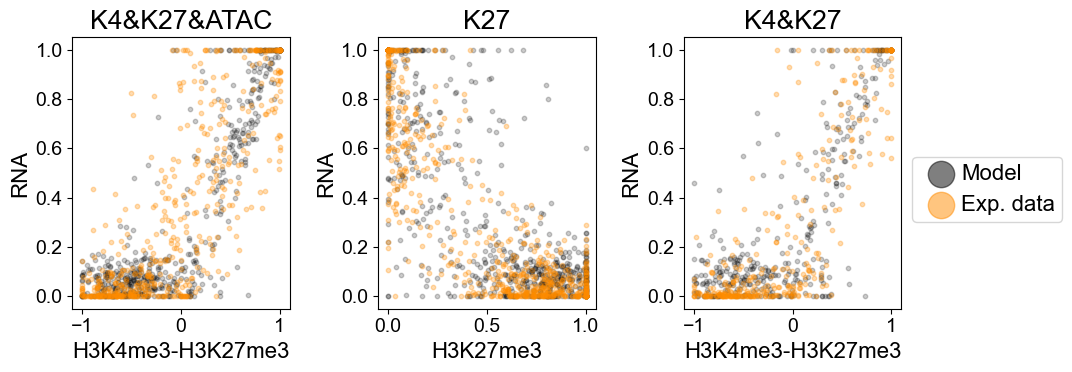

In [53]:
import matplotlib.pyplot as plt
#Plotting the qualitative comparison.
fig, ax=plt.subplots(1,3, figsize=(11,4))
for pars in range(ngenes[0]):
    ax[0].scatter(brs_ex[0][pars][:,0]-brs_ex[0][pars][:,2],rnas_ex[0][pars], c='black', s=10, alpha=0.2)
ax[0].scatter(c0_K4K27ATAC.K4-c0_K4K27ATAC.K27b, c0_K4K27ATAC.RNA, c='darkorange', s=10, alpha=0.3)
ax[0].set_title(cluster_names[0])
ax[0].set_ylabel('RNA')
ax[0].set_xlabel('H3K4me3-H3K27me3')

for pars in range(ngenes[1]):
    ax[1].scatter(brs_ex[1][pars][:,2],rnas_ex[1][pars], c='black', s=10, alpha=0.2)
ax[1].scatter(c5_K27.K27b, c5_K27.RNA, c='darkorange', s=10, alpha=0.3)
ax[1].set_title(cluster_names[1])
ax[1].set_ylabel('RNA')
ax[1].set_xlabel('H3K27me3')

for pars in range(ngenes[2]):
    if pars==0:
        ax[2].scatter(brs_ex[2][pars][:,0]-brs_ex[2][pars][:,1],rnas_ex[2][pars], c='black', s=10, alpha=0.2, label='Model')
    else:
        ax[2].scatter(brs_ex[2][pars][:,0]-brs_ex[2][pars][:,1],rnas_ex[2][pars], c='black', s=10, alpha=0.2)
ax[2].scatter(c9_K4K27.K4-c9_K4K27.K27b, c9_K4K27.RNA, c='darkorange', s=10, alpha=0.3, label='Exp. data')
ax[2].set_title(cluster_names[2])
ax[2].set_ylabel('RNA')
ax[2].set_xlabel('H3K4me3-H3K27me3')
leg = ax[2].legend(bbox_to_anchor=(1.0,0.6), markerscale=6, handletextpad=-0.1, borderpad=0.3)
for lh in leg.legend_handles:
    lh.set_alpha(0.5)

plt.tight_layout()
plt.savefig("Fig5B.png", format='png',bbox_inches='tight', dpi=300)
plt.show()